In [1]:
import os
import sys
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Ajouter manuellement le chemin vers le dossier parent du projet
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from simulation.dispo import simulation_disp
from simulation.demand import simulation_demand
from source import recolte_sang
from politics.PFA import PFA
from evaluation import complete_sim_with_peremption,complete_sim_without_peremption
from test_bench import generate_instance

In [2]:
locations,N,K,Q,alpha = generate_instance(density="medium")


In [54]:
teta_low = [300]*12
teta_target = [600, 600, 600, 340, 340, 340, 340, 340, 340, 600, 600, 600]
#teta_target = [2500]*12
policy = "PFA"
a = [0.5,0.5,0.5,0.5,0,0,-0.4,-0.4,0,0,0,0,0.5,0.5,0.5,0.5]
#a=[0]*12
final_cost,stock_history,recourse_count,peremption = complete_sim_with_peremption(teta_low, teta_target,locations,N,K,Q,alpha,policy,a,[0]*12)
print("Cout moyen : ",np.sum(final_cost))

Cout moyen :  612.3131013693862


Combination: 625/625 | Params: (-0.5, -0.25, -0.25, 0.5) | Cost: 599.7252
Meilleurs paramètres par saison : (-0.5, -0.25, -0.25, 0.5)
Coût associé : 426.87240660949976


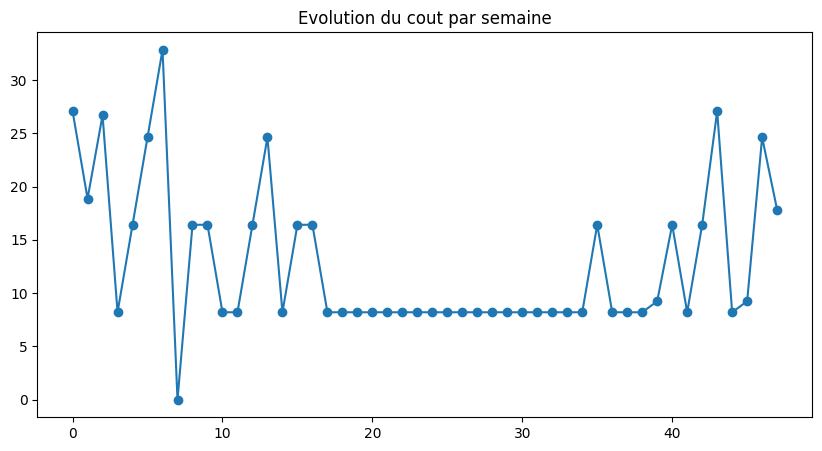

In [55]:
plt.figure(figsize=(10, 5))  # largeur=10, hauteur=5 (en pouces)
plt.title("Evolution du cout par semaine")
plt.plot(final_cost,marker='o')

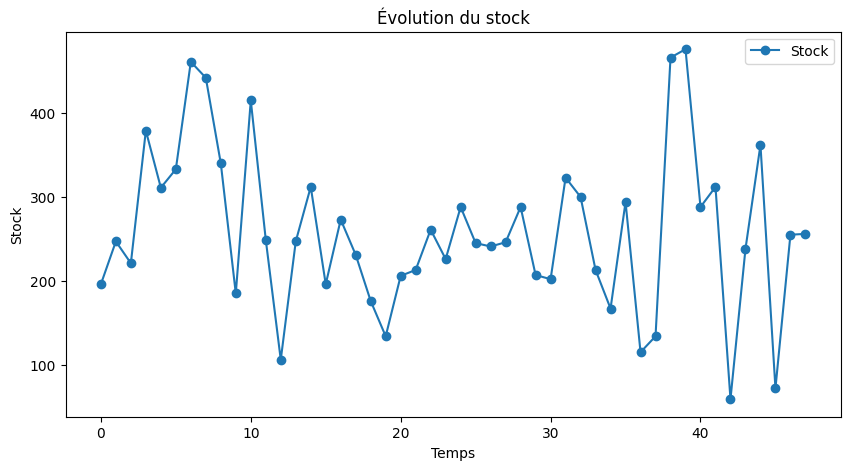

In [56]:
plt.figure(figsize=(10, 5))  
plt.title("Évolution du stock")
plt.plot(stock_history, marker='o', label="Stock") 
plt.xlabel("Temps")
plt.ylabel("Stock")
plt.legend()
plt.show()

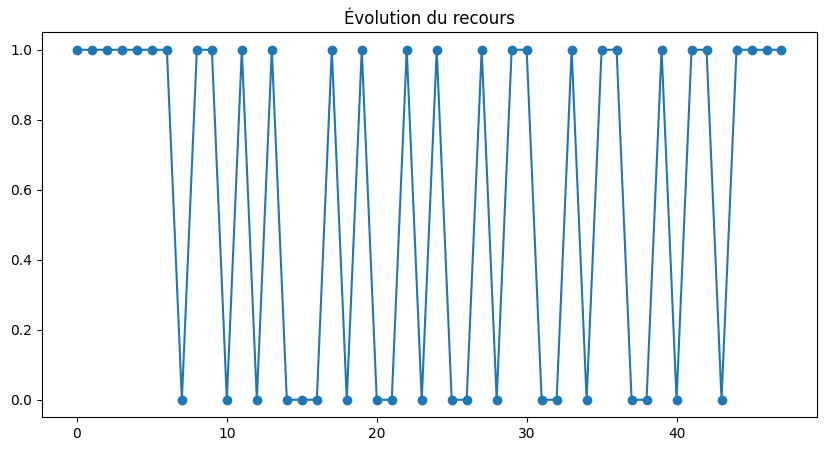

In [40]:
plt.figure(figsize=(10, 5))  
plt.title("Évolution du recours")
plt.plot(recourse_count, marker='o', label="Stock")  

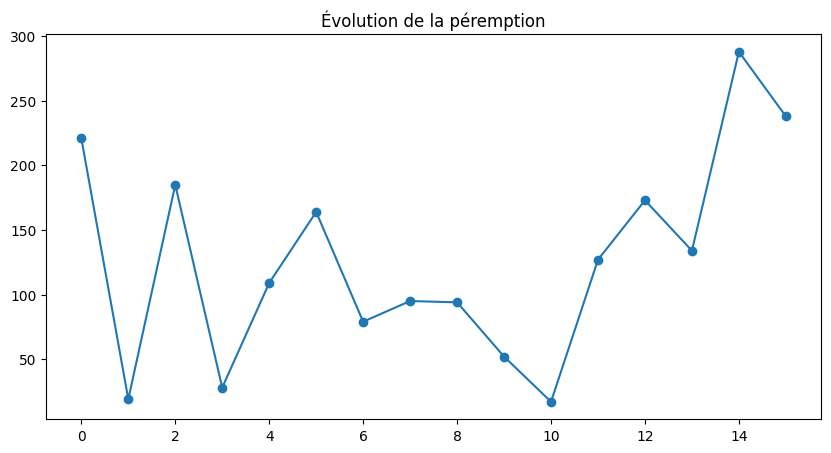

In [57]:
plt.figure(figsize=(10, 5)) 
plt.title("Évolution de la péremption")
plt.plot(peremption, marker='o', label="Stock") 